In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

please press: 
 1 to select the image by entering it`s directory 
 2 in order to capture an image 
 Anything else to Exit 
1
please enter the directory 
1


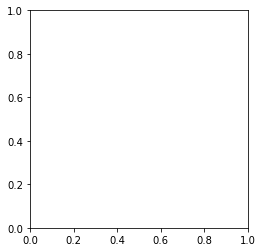

In [5]:
option=(input("please press: \n 1 to select the image by entering it`s directory \n 2 in order to capture an image \n Anything else to Exit \n"))
if   option=='1':
        directory=input('please enter the directory \n')
        img = cv2.imread(directory)
elif option=='2':
         cam=cv2.VideoCapture(0)
         while True:
            #create a frame object
            check ,img=cam.read()
            cv2.imshow("capturing",img)
            #press q key to out 
            key=cv2.waitKey(1) 
            if key==ord('q'):
                cam.release()
                cv2.destroyAllWindows()
                break
else: print('Exiting....')            

def calculate_target_size(img_size: int, kernel_size: int) -> int:
    num_pixels = 0
    
    # From 0 up to img size (if img size = 224, then up to 223)
    for i in range(img_size):
        # Add the kernel size (let's say 3) to the current i
        added = i + kernel_size
        # It must be lower than the image size
        if added <= img_size:
            # Increment if so
            num_pixels += 1
            
    return num_pixels        
def convolve(img: np.array, kernel: np.array) -> np.array:
    # Assuming a rectangular image
    tgt_size = calculate_target_size(
        img_size=img.shape[0],
        kernel_size=kernel.shape[0]
    )
    # To simplify things
    k = kernel.shape[0]
    
    # 2D array of zeros
    convolved_img = np.zeros(shape=(tgt_size, tgt_size))
    
    # Iterate over the rows
    for i in range(tgt_size):
        # Iterate over the columns
        for j in range(tgt_size):
            # img[i, j] = individual pixel value
            # Get the current matrix
            mat = img[i:i+k, j:j+k]
            
            # Apply the convolution - element-wise multiplication and summation of the result
            # Store the result to i-th row and j-th column of our convolved_img array
            convolved_img[i, j] = np.sum(np.multiply(mat, kernel))
            
    return convolved_img
try:
    plt.imshow(img)
    plt.show()
except:
    'wrong directory has been entered'
sharpen = np.array([[0, -1, 0],[-1, 1, -1],[0, -1, 0]])
outline = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])
blur = np.array([
    [0.0625, 0.125, 0.0625],
    [0.125,  0.25,  0.125],
    [0.0625, 0.125, 0.0625]
])

#img= convolve(img=np.array(img), kernel=outline)
try:
    img= convolve(img=np.array(img), kernel=sharpen)
except:
    'the convolution method isn`t working properly'

#img=cv2.imread("imgs/WIN_20220516_23_27_38_Pro.jpg")
#img = ndimage.gaussian_filter(img, sigma=(5, 5, 0), order=0)
try:
    plt.imshow(img)
    plt.show()
except:
    'wrong directory has been entered'


In [6]:
from scipy import ndimage
from scipy.ndimage.filters import convolve

from scipy import misc
import numpy as np

class cannyEdgeDetector:
    def __init__(self, img, sigma=1, kernel_size=5, weak_pixel=75, strong_pixel=255, lowthreshold=0.05, highthreshold=0.15):
        self.img =img # 0.2989 * img[:,:,0] + 0.5870 * img[:,:,1] + 0.1140 * img[:,:,2]
        self.img_smoothed = None
        self.gradientMat = None
        self.thetaMat = None
        self.nonMaxImg = None
        self.thresholdImg = None
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold
        return 
    
    def meanFilter(self,img,k):
        w,h = img.shape
        size = k // 2
        #0 padding process
        _img = np.zeros((w+2*size,h+2*size), dtype=np.uint8)
        _img[size:size+w,size:size+h] = img.copy().astype(np.uint8)
        dst = _img.copy()
        #Create filter
        ker = np.zeros((k,k), dtype=np.float)
        for x in range(-1*size,k-size):
            for y in range(-1*size,k-size):
                ker[x+size,y+size] = (1/k**2)
    
        #Filtering process
        for x in range(w):
            for y in range(h):
                dst[x+size,y+size] = np.sum(ker*_img[x:x+k,y:y+k])
    
        dst = dst[size:size+w,size:size+h].astype(np.uint8)

        return dst
    def medianFilter(img,k):
        w,h = img.shape
        size = k // 2

  #0 padding process
        _img = np.zeros((w+2*size,h+2*size), dtype=np.float)
        _img[size:size+w,size:size+h] = img.copy().astype(np.float)
        dst = _img.copy()

        #Filtering process
        for x in range(w):
            for y in range(h):
                dst[x+size,y+size] = np.median(_img[x:x+k,y:y+k])
    
        dst = dst[size:size+w,size:size+h].astype(np.uint8)

        return dst



    def sobel_filters(self, img):
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

        Ix = ndimage.filters.convolve(img, Kx)
        Iy = ndimage.filters.convolve(img, Ky)

        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return (G, theta)
    

    def non_max_suppression(self, img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180


        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255

                   #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]
                    #angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i+1, j-1]
                        r = img[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i+1, j]
                        r = img[i-1, j]
                    #angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1]
                        r = img[i+1, j+1]

                    if (img[i,j] >= q) and (img[i,j] >= r):
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0


                except IndexError as e:
                    pass

        return Z

    def threshold(self, img):

        highThreshold = img.max() * self.highThreshold;
        lowThreshold = highThreshold * self.lowThreshold;

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(self.weak_pixel)
        strong = np.int32(self.strong_pixel)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return (res)

    def hysteresis(self, img):

        M, N = img.shape
        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass

        return img

    def visualize(img, format=None, gray=False):
        plt.figure(figsize=(20, 40))
        if img.shape[0] == 3:
            img = img.transpose(1,2,0)
        plt.subplot(2, 2,1)
        plt.imshow(img, format)
        plt.show()
    def calculate_target_size(self,img_size: int, kernel_size: int) -> int:
        num_pixels = 0
        
        # From 0 up to img size (if img size = 224, then up to 223)
        for i in range(img_size):
            # Add the kernel size (let's say 3) to the current i
            added = i + kernel_size
            # It must be lower than the image size
            if added <= img_size:
                # Increment if so
                num_pixels += 1
                
        return num_pixels        
    def convolve(self,img: np.array, kernel: np.array) -> np.array:
        # Assuming a rectangular image
        tgt_size = self.calculate_target_size(
            img_size=img.shape[0],
            kernel_size=kernel.shape[0]
        )
        # To simplify things
        k = kernel.shape[0]
        
        # 2D array of zeros
        convolved_img = np.zeros(shape=(tgt_size, tgt_size))
        
        # Iterate over the rows
        for i in range(tgt_size):
            # Iterate over the columns
            for j in range(tgt_size):
                # img[i, j] = individual pixel value
                # Get the current matrix
                mat = img[i:i+k, j:j+k]
                
                # Apply the convolution - element-wise multiplication and summation of the result
                # Store the result to i-th row and j-th column of our convolved_img array
                convolved_img[i, j] = np.sum(np.multiply(mat, kernel))
                
        return convolved_img

    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        
        sharpen = np.array([[0, -1, 0],[-1, 1, -1],[0, -1, 0]])
        return  g
    def detect(self):
        
        #self.img=self.meanFilter(self.img,9)
        
        self.img_smoothed = self.convolve(img, self.gaussian_kernel(self.kernel_size, self.sigma))
        self.gradientMat, self.thetaMat = self.sobel_filters(self.img)#_smoothed)
        self.nonMaxImg = self.non_max_suppression(self.gradientMat, self.thetaMat)
        self.thresholdImg = self.threshold(self.nonMaxImg)
        img_final = self.hysteresis(self.thresholdImg)
        

        return img_final


In [7]:
try:    
    detector = cannyEdgeDetector(img, sigma=1, kernel_size=5, lowthreshold=0.05, highthreshold=0.15, weak_pixel=100)
    img_final = detector.detect()
    plt.imshow(img_final)
    plt.show()
    cannyEdgeDetector.visualize(img_final, 'gray')
except:
    'An error has occured please make sure you entered the image path correctly'
try:
    #codeList = [5, 6, 7, 4, -1, 0, 3, 2, 1]
    # This function generates the chaincode
    # for transition between two neighbour points
    def getChainCode(x1, y1, x2, y2):
        dx = x2 - x1
        dy = y2 - y1
        hashKey = 3 * dy + dx + 4
        return codeList[hashKey]            
    def generateChainCode(ListOfPoints):
        chainCode = []
        for i in range(len(ListOfPoints) - 1):
            a = ListOfPoints[i]
            b = ListOfPoints[i + 1]
            chainCode.append(getChainCode(a[0], a[1], b[0], b[1]))
        return chainCode
    print(generateChainCode(img))
except:
    'we couldn`t generate a chain code'